# Base Graph Convolutional Network

In [1]:
# import packages and reading in files:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomLinkSplit
import torch.nn.functional as F
import matplotlib.pyplot as plt

# import python files needed to create adjacency matrices
import reading_data

In [2]:
adjacency_matrix, mapping_index_to_node, mapping_entity_to_index = reading_data.create_adjacency_matrix_nt("data/aifb/aifb+.nt", literal_representation="filtered", sparse=True)
number_nodes = adjacency_matrix.size()[0]

In [18]:
# add the file names
file_name_train = "data/aifb/gz_files/aifb+_train_set.nt.gz"
file_name_valid = "data/aifb/gz_files/aifb+_valid_set.nt.gz"
file_name_test = "data/aifb/gz_files/aifb+_test_set.nt.gz"

labels, train_entities, valid_entities, test_entities = reading_data.training_valid_test_set(file_name_train, file_name_valid, file_name_test, mapping_entity_to_index, adjacency_matrix.size()[0])
train_mask = torch.tensor([i in train_entities for i in range(len(labels))])
valid_mask = torch.tensor([i in valid_entities for i in range(len(labels))])
test_mask = torch.tensor([i in test_entities for i in range(len(labels))])

In [19]:
feature_matrix = torch.sparse_coo_tensor(indices=torch.tensor([list(range(number_nodes)), list(range(number_nodes))]), values=torch.ones(number_nodes),size=(number_nodes, number_nodes))

In [32]:
# add training and test mask, add labels list

data_aifb = Data(x=feature_matrix, edge_index=adjacency_matrix.coalesce().indices(), num_nodes=number_nodes, y=labels.long(), train_mask=train_mask, test_mask=test_mask)

In [33]:
class GCN(torch.nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        super().__init__()
        self.layer1 = GCNConv(input_nodes, hidden_nodes)
        self.layer2 = GCNConv(hidden_nodes, output_nodes)
    
    def forward(self, X, A):
        h1 =  self.layer1(X, A)
        h1_activated = F.relu(h1)
        h2 = self.layer2(h1_activated, A)
        h2_activated = F.log_softmax(h2, dim=1)
        return h2_activated

In [34]:
input_n = data_aifb.num_features
hidden_n = 200
output_n = 30

model = GCN(input_n, hidden_n, output_n)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = list()

model.train()
for epoch in range(100):
    optim.zero_grad()
    
    output = model(data_aifb.x, data_aifb.edge_index)
    loss = F.nll_loss(output[data_aifb.train_mask], data_aifb.y[data_aifb.train_mask])
    loss.backward()
    optim.step()
    loss_list.append(loss.item())

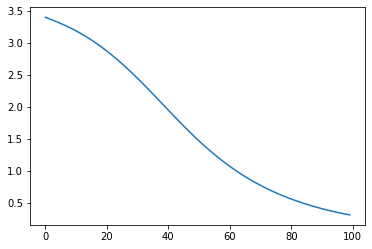

In [35]:
plt.plot(loss_list)